In [6]:
vary_speed = True

arena = generate_arena((360, 330), walls_detection_dist=4, arena_offset=[45,150])

feederA = np.array([-120, 300])
feederB = np.array([210, 270])

gutter = Wall((15, -10),(240, 260), detection=7)

In [11]:
h_p1, v_p1, T_p1, log_p1, success = modules.move(goal_coord=feederA,
                                        T_max=10000,
                                        goal_radius=10,
                                        random_exploring=True,
                                        arena=arena,
                                        stop_when_food=True,
                                        logging=True,
                                        return_success=True
                                        )
success

1

In [12]:
h_p2, v_p2, T_p2, log_p2, success = modules.move(goal_coord='Nest',
                                        T_max=2000,
                                        memory=log_p1.memory[:,-1],
                                        tb1=log_p1.tb1[:,-1],
                                        goal_radius=10,
                                        random_exploring=False,
                                        arena=arena,
                                        obstacle=gutter,
                                        stop_when_food=True,
                                        logging=True,
                                        return_success=True,
                                        inhib_gain=1.05,
                                        keep_searching=False,
                                        start_coord=feederB
                                        )

success

1

(-15, 315)

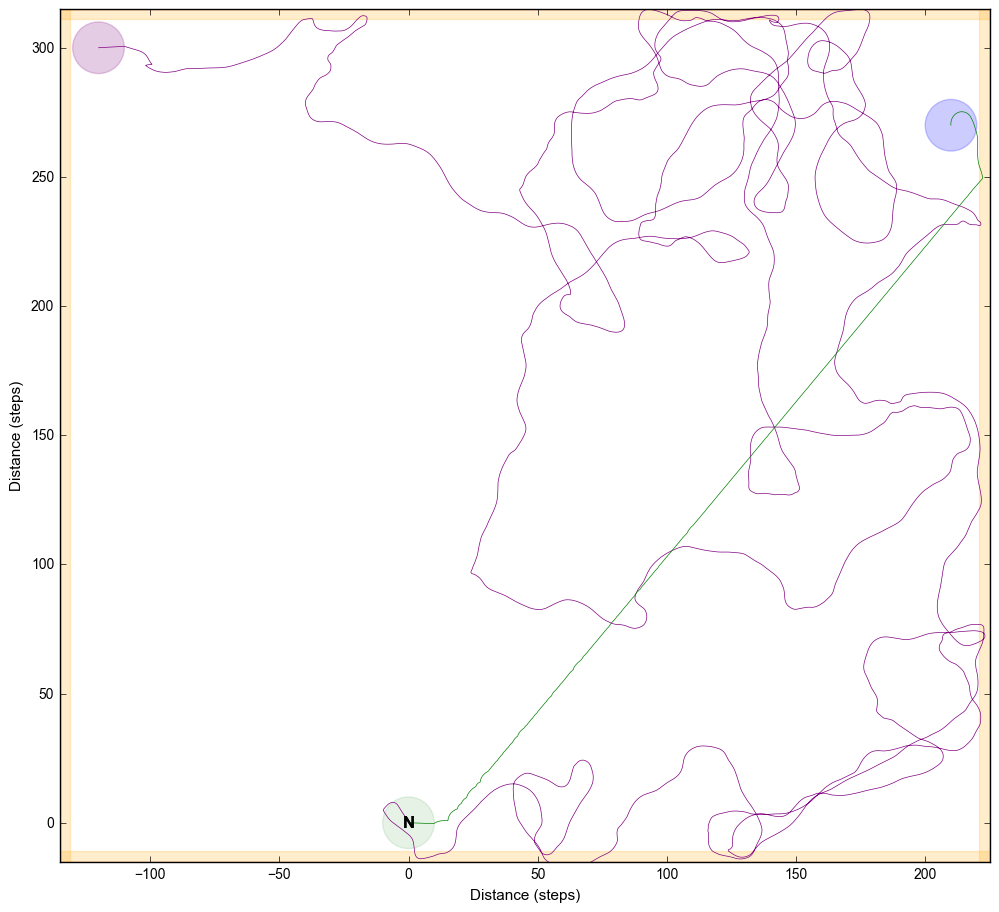

In [22]:
fig, ax = plotter2.plot_route(h_p1,
                             v_p1,
                             T_outbound=T_p1,
                             T_inbound=0,
                             plot_speed=False,
                             plot_heading=False,
                             nest_label=True,
                             legend=False,
                             figsize=figsize,
                            )

plotter2.plot_route(h_p2,
                   v_p2,
                   ax=ax,
                     T_outbound=0,
                     T_inbound=T_p2,
                     plot_speed=False,
                     plot_heading=False,
                     nest_label=True,
                     legend=False,
                     figsize=figsize,
                   start_coord=feederB
                    )

plot_arena(arena, ax=ax)
#plot_obstacle(gutter, ax=ax)

ax.add_artist(plt.Circle(feederA, 10, color='purple', alpha=.2))
ax.add_artist(plt.Circle(feederB, 10, color='blue', alpha=.2))

ax.add_artist(plt.Circle((0,0), 10, color='g', alpha=.1))
ax.set_xlim((-135, 225))
ax.set_ylim((-15, 315))

In [1]:
(np.arange(0, 11, 0.5).astype(float)/10)

NameError: name 'np' is not defined

In [107]:
gains = (np.arange(0, 11, 0.5).astype(float)/10)[:-1]
mems = np.zeros((len(gains), 16))

for g, val in enumerate(gains):
    
    mem = cx.cpu4_inhibition(log_p1.memory[:,-1], log_p2.memory[:,-1], gain=val)
    
    mems[g,:] = mem

In [114]:
N = 1
T_max = 400

HH = np.zeros((len(gains),N,T_max-1))
VV = np.zeros((len(gains),N,T_max-1,2))

for g, gain in enumerate(gains):

    H = np.zeros((N,T_max-1))
    V = np.zeros((N,T_max-1,2))

    for i in range(0,N):
        h_p3, v_p3, T_p3, log_p3, success = modules.move(#goal_coord='Nest',
                                                T_max=T_max,
                                                ltm=mems[g,:],
                                                goal_radius=10,
                                                random_exploring=False,
                                                arena=False,
                                                #obstacle=gutter,
                                                stop_when_food=True,
                                                logging=True,
                                                return_success=True,
                                                inhib_gain=1.05,
                                                keep_searching=True
                                                )

        H[i,:] = h_p3
        V[i, :,:] = v_p3
        
    HH[g,:,:] = H
    VV[g,:,:,:] = V

(-15, 315)

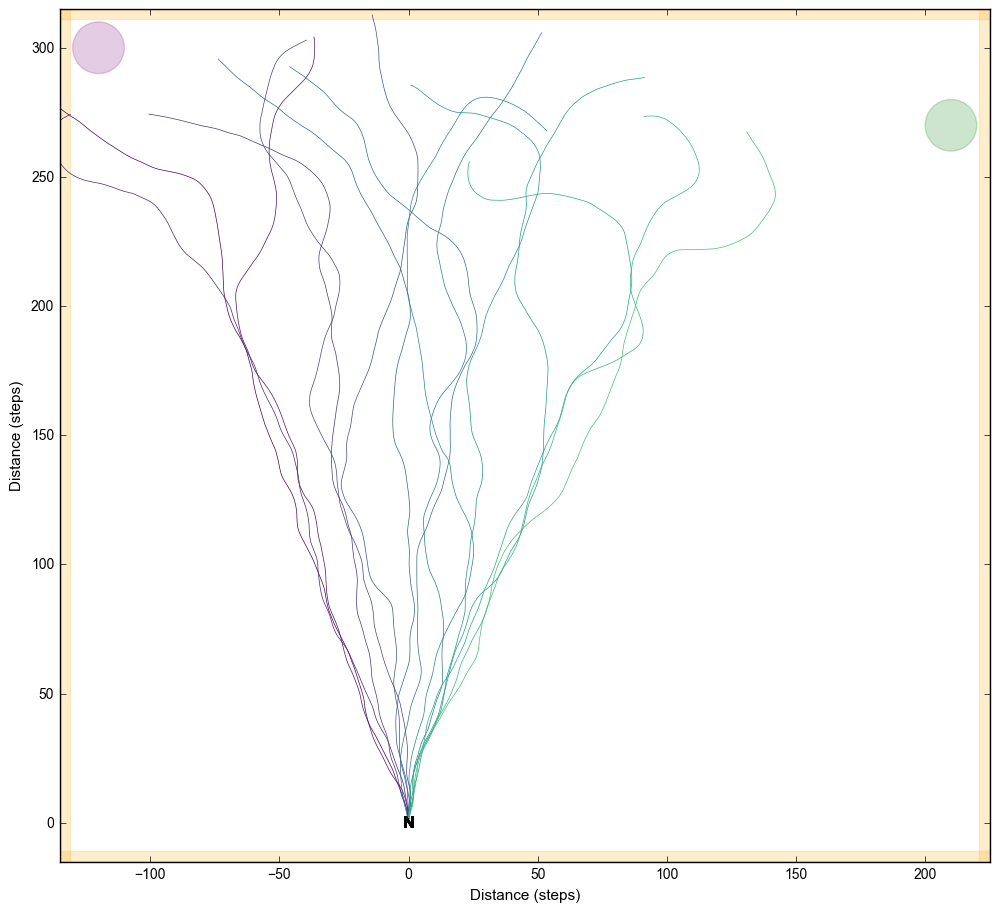

In [119]:
import matplotlib.cm as cm
colors = [plotter2.cm.viridis(x) for x in np.linspace(0, 1, len(gains))]

fig, ax = plotter2.plot_route(HH[0,0,:],
                             VV[0,0,:,:],
                             T_outbound=0,
                             T_inbound=T_max,
                             plot_speed=False,
                             plot_heading=False,
                             nest_label=True,
                             legend=False,
                             figsize=figsize,
                             inbound_color=colors[0]
                            )

for i in range(1, len(gains)-6):
    plotter2.plot_route(HH[i,0,:],
                        VV[i,0,:,:],
                       ax=ax,
                     T_outbound=0,
                     T_inbound=T_max,
                     plot_speed=False,
                     plot_heading=False,
                     nest_label=True,
                     legend=False,
                     figsize=figsize,
                    inbound_color=colors[i]
                    )

plot_arena(arena, ax=ax)
#plot_obstacle(gutter, ax=ax)

ax.add_artist(plt.Circle(feederA, 10, color='purple', alpha=.2))
ax.add_artist(plt.Circle(feederB, 10, color='green', alpha=.2))

#ax.add_artist(plt.Circle((0,0), 10, color='g', alpha=.1))
ax.set_xlim((-135, 225))
ax.set_ylim((-15, 315))

In [14]:
def generate_arena(arena_dimensions, walls_detection_dist=0, arena_offset=[0,0]):
    
    """ Generate an arena for the walled exploration experiment """
    
    arena = {'walls': np.array([[- arena_dimensions[0]/2 + arena_offset[0], arena_dimensions[0]/2 + arena_offset[0]], [- arena_dimensions[1]/2 + arena_offset[1], arena_dimensions[1]/2 + arena_offset[1]]]),
             'detection': walls_detection_dist
            }
    
    return arena

def plot_arena(arena, ax=None, figsize=(12,12)):
    
    """ Draw an arena w/ the detection zone """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    
    # Get absolute coordinates
    x1 = arena['walls'][0,0]
    x2 = arena['walls'][0,1]
    y1 = arena['walls'][1,0]
    y2 = arena['walls'][1,1]
    
    # Get dimensions
    w = np.diff(arena['walls'], axis=1)[0]
    h = np.diff(arena['walls'], axis=1)[1]
    d = arena['detection']
    
    # Draw the arena itself
    ax.add_artist(plt.Rectangle((x1, y1), w, h, color='red', alpha=0.5, fill=False))

    # Draw the detection zone
    ax.add_artist(plt.Rectangle((x1, y2-d), w, d, color='orange', alpha=0.2)) # top wall
    ax.add_artist(plt.Rectangle((x1, y1), d, h, color='orange', alpha=0.2)) # left wall
    ax.add_artist(plt.Rectangle((x1, y1), w, d, color='orange', alpha=0.2)) # bottom wall
    ax.add_artist(plt.Rectangle((x2-d, y1), d, h, color='orange', alpha=0.2)) # right wall

    return fig, ax

In [ ]:
# Define the feeders coordinates
to_be_found = np.zeros([2,2])

# Same as Buatois & Lihoreau 2016
to_be_found[0,:] = (-37, 397)
to_be_found[1,:] = (-142, 611)
to_be_found[2,:] = (-219, 484)
to_be_found[3,:] = (-176, 193)

In [ ]:
# Arena params
arena_dimensions = [500, 450]
arena_offset = [-300, 300]
walls_detection_dist = 7

# And actually generate the arena
arena = generate_arena(arena_dimensions, walls_detection_dist)

In [ ]:
guide = Wall((-195, 180), (-10, -15))
guide2 = Wall(to_be_found[3,:], to_be_found[0,:])
cylinder = Cylinder((-70, 350), 60)

In [ ]:
# Try to find Feeder 0

food_quantity = [1, 1]
success = 0

h_p1, v_p1, T_p1, log_p1, success = modules.move(goal_coord=to_be_found[0],
                                                 T_max=6000,
                                                 goal_radius=feeder_radius,
                                                 random_exploring=True,
                                                 arena=arena,
                                                 stop_when_food=True,
                                                 logging=True,
                                                 return_success=True,
                                                 inhib_gain=1.25
                                                )

if success == 0:
    print('Fail :(')
else:
    print('Success!')

In [ ]:
# Store memory for Feeder 0
memF0 = log_p1.memory[:,-1]

In [ ]:
# Try to find Feeder 1

food_quantity = [1, 1]
success = 0

h_p2, v_p2, T_p2, log_p2, success = modules.move(goal_coord=to_be_found[1],
                                                 T_max=6000,
                                                 goal_radius=feeder_radius,
                                                 random_exploring=True,
                                                 arena=arena,
                                                 stop_when_food=True,
                                                 logging=True,
                                                 return_success=True,
                                                 inhib_gain=1.05
                                                )

if success == 0:
    print('Fail :(')
else:
    print('Success!')

In [ ]:
# Store memory for Feeder 1

memF1 = log_p2.memory[:,-1]

In [ ]:
# Go back to Feeder 0 (in a straight food-ward route)

h_p1b, v_p1b, T_p1b, log_p1b, success = modules.move(goal_coord=to_be_found[0],
                                             ltm=memF0,
                                             T_max=3000,
                                             goal_radius=feeder_radius,
                                             random_exploring=False,
                                             arena=arena,
                                             stop_when_food=True,
                                             logging=True,
                                             return_success=True,
                                             inhib_gain=1.05
                                            )

if success == 1:
    print('Success!')
else:
    print('Fail :(')

In [ ]:
# Go back to Feeder 1 (in a straight food-ward route)

h_p2b, v_p2b, T_p2b, log_p2b, success = modules.move(goal_coord=to_be_found[1],
                                             ltm=memF1,
                                             T_max=3000,
                                             goal_radius=feeder_radius,
                                             random_exploring=False,
                                             arena=arena,
                                             stop_when_food=True,
                                             logging=True,
                                             return_success=True,
                                             inhib_gain=1.05
                                            )

if success == 1:
    print('Success')
else:
    print('fail')

In [ ]:
memF0b = log_p1b.memory[:,-1]
memF1b = log_p2b.memory[:,-1]

# Below are the latest experimentations with traplining

In [ ]:
storage = []
memories = [None]
repetitions = 5

for n in range(1, repetitions+1):
    
    print('Start :')
    print(n)
    print('---')
    
    if n <= len(to_be_found):
        exp = range(n)
    else:
        exp = range(len(to_be_found))

    food_quantity = np.ones(len(exp))/len(exp)

    crop_filling = 0.0
    last_stop = np.array([0.0, 0.0])
    
    T_full = 0
    h_full = np.array([0.0])
    v_full = np.array([0.0, 0.0])

    end_mem = None
    end_tb1 = None
    state = None
    index = None
    visited = []
    runs = []
    
    while crop_filling < 1.0:

        if memories[n-1]:
            print('Memories available')
            selected_mem, goal_index = get_next_goal(memories[n-1], current_mem=end_mem, min_distance=60.0, max_distance=500, to_ignore=None, use_food=False, mode='max')
            
            if selected_mem is not None:
                state = 'goal_loaded'
                print('Memory selected:')
                print(goal_index)
            else:
                state = 'explore'
                print('Memory selected:')
                print('Aucune, pass')
        else:
            state = 'explore'
            print('No memories available')
            print('---')


        ########################################################
        if state == 'goal_loaded':
            print('Mem flight :')
            h_p1, v_p1, T_p1, log_p1, success = move(
                                                goal_coord=to_be_found[exp],
                                                memory=end_mem,
                                                tb1=end_tb1,
                                                ltm=selected_mem,
                                                start_coord=last_stop,
                                                T_max=2000,
                                                goal_radius=feeder_radius,
                                                random_exploring=False,
                                                arena=arena,
                                                stop_when_food=True,
                                                #current_heading=h_run[-1],
                                                #current_velocity=v_run[-1],
                                                logging=True,
                                                return_success=True
                                                )
            
            if success == 1:
                print('OK')
                h_run = h_p1
                v_run = v_p1
                T_run = T_p1
                
                log_run = log_p1
                
            else:
                print('Not found')
                
                pause = np.cumsum(np.vstack((v_full, v_p1)), axis=0)[-1]
                print('Attempting to explore :')
                h_p2, v_p2, T_p2, log_p2, success = move(
                                                goal_coord=to_be_found[exp],
                                                memory=log_p1.memory[:,-1],
                                                tb1=log_p1.tb1[:,-1],
                                                ltm=None,
                                                start_coord=pause,
                                                T_max=20000,
                                                goal_radius=feeder_radius,
                                                random_exploring=True,
                                                arena=arena,
                                                stop_when_food=True,
                                                current_heading=h_p1[-1],
                                                current_velocity=v_p1[-1],
                                                logging=True,
                                                return_success=True
                                                )
                
                if success == 1:
                    print('OK')
                    h_run = np.hstack((h_p1, h_p2))
                    v_run = np.vstack((v_p1, v_p2))
                    T_run = T_p1 + T_p2
                    
                    log_run = log_p1 + log_p2
                    
                else:
                    print('Not found sorry :(')
                    break
                    state = 'explore'
                    print('...again...')

        #####
        
        if state == 'explore':
            print('Discovery flight :')
            h_run, v_run, T_run, log_run, success = move(
                                                goal_coord=to_be_found[exp],
                                                memory=end_mem,
                                                tb1=end_tb1,
                                                ltm=None,
                                                start_coord=last_stop,
                                                T_max=30000,
                                                goal_radius=feeder_radius,
                                                random_exploring=True,
                                                arena=arena,
                                                stop_when_food=True,
                                                #current_heading=h_run[-1],
                                                #current_velocity=v_run[-1],
                                                logging=True,
                                                return_success=True
                                                )
            
            if success == 1:
                print('OK')

            else:
                print('Not found')
                break
                
        ########################

        to_save = log_run.memory[:,-1]
        
        h_full = np.hstack((h_full, h_run))
        v_full = np.vstack((v_full, v_run))
        T_full += T_run

        end_mem = log_run.memory[:,-1]
        end_tb1 = log_run.tb1[:,-1]
        last_stop = np.cumsum(v_full, axis=0)[-1]
        
        ########################################################
        
        where, = np.where(np.sqrt((last_stop[0] - to_be_found[:,0])**2 + (last_stop[1] - to_be_found[:,1])**2) <= 13)
        
        if len(where) > 0:
            index = int(where)
            intake = food_quantity[index]
        else:
            index = None
            intake = 0

        print('Feeder found:', 'Food acquired:')
        print(index, intake)

        if intake > 0:

            crop_filling += intake
            food_quantity[index] -= intake

            runs.append([index, to_save, intake])
            visited.append(index)

        del intake
        
    discovered.append(visited)   
    memories.append(runs)
    storage.append([h_full, v_full, T_full])
    print('End :')
    print(n)
    print('___')

In [ ]:
memories[4]

In [ ]:
h_plot, v_plot, T_plot = storage[1]

In [ ]:
fig, ax = plotter2.plot_route(h_plot,
                             v_plot,
                             T_outbound=500,
                             T_inbound=0,
                             plot_speed=False,
                             plot_heading=False,
                             nest_label=True,
                             legend=False,
                             figsize=figsize,
                            )

plot_arena(arena, ax=ax, figsize=figsize)

ax.add_artist(plt.Circle((0, 0), nest_radius, color='green', alpha=0.3))

for i in range(0, len(to_be_found)):
    plt.scatter(to_be_found[i,0], to_be_found[i,1], marker='x', color='orange', s=40, linewidth=0.6)
    ax.add_artist(plt.Circle(to_be_found[i,:], feeder_radius, color='purple', alpha=0.1))

    plt.text(to_be_found[i,0]+1.5, to_be_found[i,1]+2, 'F{0}'.format(i), fontsize=11, fontweight='regular', color='grey')

In [ ]:
#memories = [None]
repetitions = 1

for n in range(1, repetitions+1):
    
    print('start, repetition:',n)
    if n <= len(to_be_found):
        exp = range(n)
    else:
        exp = range(len(to_be_found))

    #goals_coords = np.zeros([len(np.atleast_1d(exp)), 2])
    #exp = np.sort(np.atleast_1d(exp))

    #for e in range(len(np.atleast_1d(exp))):
    #    goals_coords[e,:] = to_be_found[exp[e],:]

    # Refill feeders
    #feeders_refill = np.zeros(to_be_found.size/2)
    #food = np.ones(goals_coords.size/2)/(goals_coords.size/2)

    #for e,f in zip(np.atleast_1d(exp), range(len(np.atleast_1d(food)))):
    #    feeders_refill[e] = food[f]

    #food_quantity = feeders_refill
    food_quantity = np.ones(len(exp))/len(exp)

    crop_filling = 0.0
    start_coord = np.array([0.0, 0.0])
    
    T_full = 0
    h_full = np.array([0.0])
    v_full = np.array([0.0, 0.0])

    log_full = None
    log_flight = None
    log_explore = None
    endstate = None
    state = None
    index = None
    
    while crop_filling < 1:

        if memories[n-1]:
            
            selected_mem, index = get_next_goal(memories[1], current_mem=log_p1.memory[:,-1], max_distance=500, to_ignore=None, use_food=False, mode='max')
            
            if selected_mem is not None:
                state = 'goal_loaded'
                print('memory_selected')
            else:
                state = 'explore'
                print('pass')
        else:
            state = 'explore'
            print('no_memories')

        ########################################################
        if state == 'goal_loaded':
            h_flight, v_flight, log_flight, T_flight, success = flight2(T=3500,
                                                                        memory=endstate,
                                                                        ltm=selected_mem,
                                                                        arena=arena,
                                                                        stop_when_food=True,
                                                                        start_coord=start_coord,
                                                                        goal_coord=to_be_found,
                                                                        goal_radius=feeder_radius,
                                                                        acceleration=0.1,
                                                                        current_heading=h_full[-1],
                                                                        current_velocity=v_full[-1],
                                                                        logging=True)
            if success == 1:
                print('ok')
                h_run = h_flight
                v_run = v_flight
                T_run = T_flight
                
            else:
                print('not ok')
                h_explore, v_explore, T_explore, success = explore(to_be_found,
                                                          start_coord=np.cumsum(v_flight, axis=0)[-1],
                                                          arena=arena,
                                                          stop_when_food=True,
                                                          current_heading=h_flight[-1],
                                                          current_velocity=v_flight[-1],
                                                          goal_radius=feeder_radius)
                
                h_run = np.hstack((h_flight, h_explore))
                v_run = np.vstack((v_flight, v_explore))
                T_run = T_flight + T_explore
                
        else:
            h_run, v_run, T_run, success = explore(to_be_found,
                                          start_coord=start_coord,
                                          arena=arena,
                                          stop_when_food=True,
                                          current_heading=h_full[-1],
                                          current_velocity=v_full[-1],
                                          goal_radius=feeder_radius,
                                          )

        h_full = np.hstack((h_full, h_run))
        v_full = np.vstack((v_full, v_run))
        T_full += T_run
        log_full = trials.generate_memory(h_full, v_full, cx, logging=True)
        
        success = 0
        
        ########################################################
        
        start_coord = np.cumsum(v_full, axis=0)[-1]

        where, = np.where(np.sqrt((start_coord[0] - to_be_found[:,0])**2 + (start_coord[1] - to_be_found[:,1])**2) <= 6)
        #print(start_coord, where)

        endstate = log_full.memory[:,-1]
        
        if len(where) > 0:
            index = int(where)
            intake = food_quantity[index]
        else:
            index = None
            intake = 0

        print(intake)

        if intake > 0:

            crop_filling += intake
            food_quantity[index] -= intake

            memories.append([index, log_full, intake])
            
        del intake
        
    if n <= len(to_be_found):
        memories = memories[n:]
    else:
        memories = memories[len(to_be_found):]
        
    print(memories)
            
    storage.append([h_full, v_full, T_full])

In [ ]:
storage = []

runs = 5

for n in range(runs):
    
    if n < len(to_be_found):
        exp = range(n+1)
    else:
        exp = range(len(to_be_found))
    
    if n == 0:
        memories = []

    goals_coords = np.zeros([len(np.atleast_1d(exp)),2])
    exp = np.sort(np.atleast_1d(exp))

    for e in range(len(np.atleast_1d(exp))):
        goals_coords[e,:] = to_be_found[exp[e],:]


    # Refill feeders
    empty_feeders = np.zeros(to_be_found.size/2)
    food = np.ones(goals_coords.size/2)/(goals_coords.size/2)

    for e,f in zip(np.atleast_1d(exp), range(len(np.atleast_1d(food)))):
        empty_feeders[e] = food[f]

    food_quantity = empty_feeders

    crop_filling = 0.0
    start_coord = np.array([0.0, 0.0])
    T_tot = 0
    h_tot = np.array([0.0])
    v_tot = np.array([0.0, 0.0])

    current_mem = None
    state = None
    index = None
    
    while crop_filling < 1:

        if memories:
            
            #print('to ignore:', index)
            selected_mem, _ = get_next_goal(memories, current_mem=current_mem, max_distance=None, to_ignore=index, use_food=False, mode='weight')

            print(selected_mem, _)
            if selected_mem is not None:
                state = 'goal_loaded'
            else:
                state = 'explore'

        else:
            #print('no_mem')
            state = 'explore'

        ########################################################

        if state == 'goal_loaded':

            h_thisstep, v_thisstep, log_thisstep, T_thisstep, success = flight(T=1500,
                                                                      memory=selected_mem,
                                                                      forage=False,
                                                                      arena=arena,
                                                                      start_coord=start_coord,
                                                                      goal_coord=goals_coords,
                                                                      goal_radius=feeder_radius,
                                                                      acceleration=0.1,
                                                                      current_heading=h_tot[-1],
                                                                      current_velocity=v_tot[-1],
                                                                      logging=False
                                                                      )

            #if success == 1:

                #print('ok')

            #else:
            if success == 0:

                #print('not ok')
                state = 'explore'

        if state == 'explore':
             h_thisstep, v_thisstep, T_thisstep = explore(to_be_found,
                                                          start_coord=start_coord,
                                                          arena=arena,
                                                          stop_when_food=True,
                                                          current_heading=h_tot[-1],
                                                          current_velocity=v_tot[-1],
                                                          goal_radius=feeder_radius,
                                                         )

        ########################################################

        if T_tot > 0:
            h_tot = np.hstack((h_tot, h_thisstep))
            v_tot = np.vstack((v_tot, v_thisstep))
            T_tot += T_thisstep
        else:
            h_tot = h_thisstep
            v_tot = v_thisstep
            T_tot = T_thisstep

        current_mem = trials.generate_memory(h_tot, v_tot, cx, logging=True)

        start_coord = np.cumsum(v_tot, axis=0)[-1]

        where, = np.where(np.sqrt((start_coord[0] - to_be_found[:,0])**2 + (start_coord[1] - to_be_found[:,1])**2) <= 1e-9)
        #print(start_coord, where)

        if len(where) > 0:
            index = int(where)
            intake = food_quantity[index]
        else:
            index = None
            intake = 0

        #print(intake)

        if intake > 0:

            crop_filling += intake
            food_quantity[index] -= intake

            memories.append([index, current_mem, intake])

        del h_thisstep, v_thisstep, T_thisstep, intake

    if n <= len(to_be_found):
        memories = memories[n:]
    else:
        memories = memories[len(to_be_found):]
        
    storage.append([h_tot, v_tot, T_tot])